# Finding and plotting NetCDF data in the CEDA Archive

This Notebook demonstrates a few capabilities of the JASMIN Notebook service:
* Reading data from the CEDA Archive
* Analysing/processing data in the Notebook
* Plotting the results interactively
* Writing the outputs to your JASMIN `$HOME` directory
* Adding inline documentation

## Task 1: Find and read ECMWF ERA5 2-metre temperature data

This task involves two parts: (1) Finding the relevant ECMWF ERA5 file paths and (2) Reading a file path pattern into an `xarray Dataset` object.

Part (1) can be done in various ways. For the sake of simplicity, we have already searched the CEDA catalogue and found this dataset record:

https://catalogue.ceda.ac.uk/uuid/8aa70a91378d455ea63a2a1953858a7f

Following the "Download" link on the page reveals a browseable data path that reveals the 2-metre temperature data can be found under:

https://data.ceda.ac.uk/badc/ecmwf-era51/data/oper/an_sfc/2005/01/01 (e.g. file: `ecmwf-era51_oper_an_sfc_200501010000.2t.nc`)

On the file system, this translates to this pattern:

`/badc/ecmwf-era51/data/oper/an_sfc/2005/01/01/ecmwf-era51_oper_an_sfc_20050101*.2t.nc`
    
For Part (2)...

Import the `xarray` library as `xr`:

In [1]:
import xarray as xr

Use `xr.open_mfdataset(...)` to read in the file pattern defined above to read in the hourly 2-metre temperature files.

In [2]:
file_pattern = "/badc/ecmwf-era51/data/oper/an_sfc/2005/01/01/ecmwf-era51_oper_an_sfc_20050101*.2t.nc"

# Or you could make a generic template in a function
def get_template(year, month, day, variable):
    return (f"/badc/ecmwf-era51/data/oper/an_sfc/{year}/{month}/{day}/"
            f"ecmwf-era51_oper_an_sfc_{year}{month}{day}*.{variable}.nc")

year, month, day = "2005", "01", "01"
var_id = "2t" # 2-metre temperature
file_pattern = get_template(year, month, day, var_id)
file_pattern

'/badc/ecmwf-era51/data/oper/an_sfc/2005/01/01/ecmwf-era51_oper_an_sfc_20050101*.2t.nc'

Check we have some valid files using `glob`

In [3]:
import glob
files = glob.glob(file_pattern)
len(files)

24

Open the files as a single `xarray Dataset` and take a look at its structure, attributes and time values:

In [4]:
ds = xr.open_mfdataset(file_pattern)
ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 24)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2005-01-01 ... 2005-01-01T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 dask.array<shape=(24, 721, 1440), chunksize=(1, 721, 1440)>
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-26 02:16:17 GMT by grib_to_netcdf-2.17.1: grib_to_n...

In [5]:
ds.t2m.attrs

OrderedDict([('units', 'K'), ('long_name', '2 metre temperature')])

In [6]:
ds.time.values

array(['2005-01-01T00:00:00.000000000', '2005-01-01T01:00:00.000000000',
       '2005-01-01T02:00:00.000000000', '2005-01-01T03:00:00.000000000',
       '2005-01-01T04:00:00.000000000', '2005-01-01T05:00:00.000000000',
       '2005-01-01T06:00:00.000000000', '2005-01-01T07:00:00.000000000',
       '2005-01-01T08:00:00.000000000', '2005-01-01T09:00:00.000000000',
       '2005-01-01T10:00:00.000000000', '2005-01-01T11:00:00.000000000',
       '2005-01-01T12:00:00.000000000', '2005-01-01T13:00:00.000000000',
       '2005-01-01T14:00:00.000000000', '2005-01-01T15:00:00.000000000',
       '2005-01-01T16:00:00.000000000', '2005-01-01T17:00:00.000000000',
       '2005-01-01T18:00:00.000000000', '2005-01-01T19:00:00.000000000',
       '2005-01-01T20:00:00.000000000', '2005-01-01T21:00:00.000000000',
       '2005-01-01T22:00:00.000000000', '2005-01-01T23:00:00.000000000'],
      dtype='datetime64[ns]')

## Task 2: Calculate the max and min over all times in the dataset

You can access the 2-metre temperature variable using: `ds.t2m`.

The `ds.t2m Dataset` has its own methods: `max()` and `min()`. They require the argument `axis=0` in order to specify calculating the _max_ and _min_ only over the time axis.

Calculate two new variables:
1. `daily_max` - the maximum over all times
2. `daily_min` - the minimum over all times

In [7]:
daily_max = ds.t2m.max(axis=0)
daily_min = ds.t2m.min(axis=0)

Check the `shape` attribute of the `daily_max` and `daily_min` variables to ensure they are 2D (i.e. `time` has been removed).

In [8]:
daily_max.shape, daily_min.shape

((721, 1440), (721, 1440))

## Task 3: Plot the daily maximum and minimum

Typically, in a Notebook environment, you need this line before trying to view plots inline.

In [9]:
%matplotlib inline

The `daily_max` and `daily_min` variables now both have a `plot()` method. You can plot each of them individually.

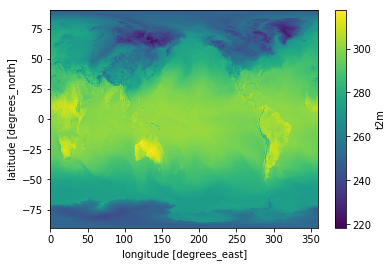

In [10]:
daily_max.plot()

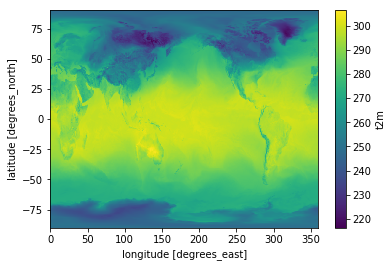

In [11]:
daily_min.plot()

You can difference them and plot a map of that variable

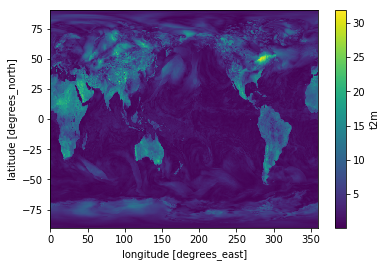

In [12]:
diff = daily_max - daily_min
diff.plot()

## Task 4: Write the outputs to your JASMIN `$HOME` directory

Create an `outputs` directory in your `$HOME` directory

In [13]:
import os
output_dir = f"{os.environ['HOME']}/outputs"

if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

Write the `daily_max` and `daily_min` variables to NetCDF files, using the `to_netcdf()` method on each variable. The method requires the output file path as the argument.


In [14]:
daily_max.to_netcdf(f"{output_dir}/max_t2m.nc")

In [15]:
daily_min.to_netcdf(f"{output_dir}/min_t2m.nc")

Check that the output files have been written to the `outputs` directory

In [16]:
os.listdir(output_dir)

['max_t2m.nc', 'min_t2m.nc']

## Task 5: Add inline documentation

For each cell, you can select either "Code", "Markdown" or "Raw" in the toolbar at the top of the notebook. If you select "Markdown", then the cell is no longer interpreted as Python code. Instead, it is interpreted as a mark-up language called `markdown`. This allows sophisticated formatting of text, images, code blocks etc., as described here:

https://guides.github.com/features/mastering-markdown/

In order to add Markdown cells to an existing notebook, click on the cell above the one you wish to annotate, then click the `+` button on the toolbar. Then change the cell format to "Markdown" in the drop-down menu.

Once you have completed the content, press `Shift+Enter` to see the formatted version. If you need to edit a formatted cell, just double-click into it.